### Ce notebook tourne en version 1.4.x de qiskit.


## Introduction

Many problems in quantitative fields such as finance and engineering are optimization problems. Optimization problems lie at the core of complex decision-making and definition of strategies. 

Optimization (or combinatorial optimization) means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized. This is typically called cost function or objective function. 

**Typical optimization problems**

Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects

Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects 

We consider here max-cut problems of practical interest in many fields, and show how they can be mapped on quantum computers manually and how Qiskit optimization module supports this.

### En français 
- Optimisation des réseaux : séparation optimale de réseaux pour minimiser l’interférence entre sous-réseaux.
- Problèmes de clustering : classification de données en groupes bien séparés.
- Physique statistique : modélisation des transitions de phase dans des systèmes physiques comme les spins des particules.
- Cryptographie et sécurité : détection des faiblesses dans les structures de réseaux.



### Weighted Max-Cut

Max-Cut is an NP-complete problem, with applications in clustering, network science, and statistical physics. To grasp how practical applications are mapped into given Max-Cut instances, consider a system of many people that can interact and influence each other. Individuals can be represented by vertices of a graph, and their interactions seen as pairwise connections between vertices of the graph, or edges. With this representation in mind, it is easy to model typical marketing problems. For example, suppose that it is assumed that individuals will influence each other's buying decisions, and knowledge is given about how strong they will influence each other. The influence can be modeled by weights assigned on each edge of the graph. It is possible then to predict the outcome of a marketing strategy in which products are offered for free to some individuals, and then ask which is the optimal subset of individuals that should get the free products, in order to maximize revenues.

The formal definition of this problem is the following:

Consider an $n$-node undirected graph *G = (V, E)* where *|V| = n* with edge weights $w_{ij}>0$, $w_{ij}=w_{ji}$, for $(i, j)\in E$. A cut is defined as a partition of the original set V into two subsets. The cost function to be optimized is in this case the sum of weights of edges connecting points in the two different subsets, *crossing* the cut. By assigning $x_i=0$ or $x_i=1$ to each node $i$, one tries to maximize the global profit function (here and in the following summations run over indices 0,1,...n-1)

$$\tilde{C}(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j).$$

In our simple marketing model, $w_{ij}$ represents the probability that the person $j$ will buy a product after $i$ gets a free one. Note that the weights $w_{ij}$ can in principle be greater than $1$ (or even negative), corresponding to the case where the individual $j$ will buy more than one product. Maximizing the total buying probability corresponds to maximizing the total future revenues. In the case where the profit probability will be greater than the cost of the initial free samples, the strategy is a convenient one. An extension to this model has the nodes themselves carry weights, which can be regarded, in our marketing model, as the likelihood that a person granted with a free sample of the product will buy it again in the future. With this additional information in our model, the objective function to maximize becomes 

$$C(\textbf{x}) = \sum_{i,j} w_{ij} x_i (1-x_j)+\sum_i w_i x_i. $$
 
In order to find a solution to this problem on a quantum computer, one needs first to map it to an Ising Hamiltonian. This can be done with the assignment $x_i\rightarrow (1-Z_i)/2$, where $Z_i$ is the Pauli Z operator that has eigenvalues $\pm 1$. Doing this we find that 

$$C(\textbf{Z}) = \sum_{i,j} \frac{w_{ij}}{4} (1-Z_i)(1+Z_j) + \sum_i \frac{w_i}{2} (1-Z_i) = -\frac{1}{2}\left( \sum_{i<j} w_{ij} Z_i Z_j +\sum_i w_i Z_i\right)+\mathrm{const},$$

where $\mathrm{const} = \sum_{i<j}w_{ij}/2+\sum_i w_i/2$. In other terms, the weighted Max-Cut problem is equivalent to minimizing the Ising Hamiltonian 

$$ H = \sum_i w_i Z_i + \sum_{i<j} w_{ij} Z_iZ_j.$$

Qiskit optimization module can generate the Ising Hamiltonian for the first profit function $\tilde{C}$.
To this extent, function $\tilde{C}$ can be modeled as a `QuadraticProgram`, which provides the `to_ising()` method.


### Approximate Universal Quantum Computing for Optimization Problems

There has been a considerable amount of interest in recent times about the use of quantum computers to find a solution to combinatorial optimization problems. It is important to say that, given the classical nature of combinatorial problems, exponential speedup in using quantum computers compared to the best classical algorithms is not guaranteed. However, due to the nature and importance of the target problems, it is worth investigating heuristic approaches on a quantum computer that could indeed speed up some problem instances. Here we demonstrate an approach that is based on the *Quantum Approximate Optimization Algorithm* (QAOA) by Farhi, Goldstone, and Gutmann (2014). We frame the algorithm in the context of *approximate quantum computing*, given its heuristic nature. 

The algorithm works as follows:

1. Choose the $w_i$ and $w_{ij}$ in the target Ising problem. In principle, even higher powers of Z are allowed.

1. Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.

1. Choose a set of controls $\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$. 

1. Evaluate 
$$C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H|~\psi(\boldsymbol\theta)\rangle = \sum_i w_i \langle\psi(\boldsymbol\theta)~|Z_i|~\psi(\boldsymbol\theta)\rangle+ \sum_{i<j} w_{ij} \langle\psi(\boldsymbol\theta)~|Z_iZ_j|~\psi(\boldsymbol\theta)\rangle$$ 
by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen. 

1. Use a classical optimizer to choose a new set of controls.

1. Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.

1. Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $|\langle z_i~|\psi(\boldsymbol\theta)\rangle|^2\;\forall i$ to obtain the answer.
    
It is our belief the difficulty of finding good heuristic algorithms will come down to the choice of an appropriate trial wavefunction. For example, one could consider a trial function whose entanglement best aligns with the target problem, or simply make the amount of entanglement a variable. In this tutorial, we will consider a simple trial function of the form

$$|\psi(\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, where $n$ is the number of qubits and $m$ is the depth of the quantum circuit. The motivation for this choice is that for these classical problems this choice allows us to search over the space of quantum states that have only real coefficients, still exploiting the entanglement to potentially converge faster to the solution.

One advantage of using this sampling method compared to adiabatic approaches is that the target Ising Hamiltonian does not have to be implemented directly on hardware, allowing this algorithm not to be limited to the connectivity of the device. Furthermore, higher-order terms in the cost function, such as $Z_iZ_jZ_k$, can also be sampled efficiently, whereas in adiabatic or annealing approaches they are generally impractical to deal with. 

## En résumé, un bon dessin vaut mieux que ...

![alt text](vqe.png)


References:

- \ A. Lucas, Frontiers in Physics 2, 5 (2014)
- \ E. Farhi, J. Goldstone, S. Gutmann, e-print arXiv 1411.4028 (2014)
- \ D. Wecker, M. B. Hastings, M. Troyer, Phys. Rev. A 94, 022309 (2016)
- \ E. Farhi, J. Goldstone, S. Gutmann, H. Neven, e-print arXiv 1703.06199 (2017)

In [1]:
import qiskit
print(qiskit.version.get_version_info())

1.4.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

### Force Brute


In [ ]:
# Generation du graphe
# PETITE CONFIGURATION : 4 vertices et 5 edges, poids constants 
n = 4
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
# tuple is (i,j,weight) where (i,j) is the edge G.add_weighted_edges_from(elist)
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos) 
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

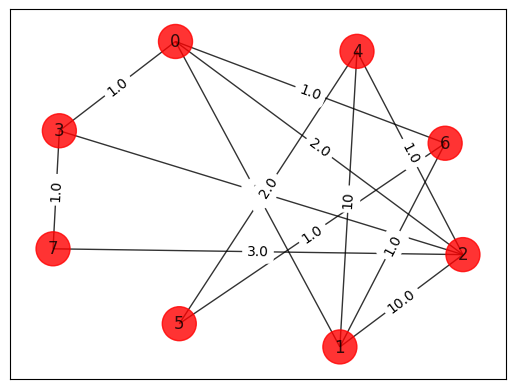

In [3]:
# Generation du graphe "grande config", 8 edges
n = 8 # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
# tuple is (i,j,weight) where (i,j) is the edge G.add_weighted_edges_from(elist)
#elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)] # tuple is (i,j,weight) where (i,j) is the edge G.add_weighted_edges_from(elist)
# mieux :
elist = [(0, 1, 1.0), (0, 2, 2.0), (0, 3, 1.0), (1, 2, 10.0), (2, 3, 1.0),
         (2,7,3.0),(5,6,1.0),(4,5,2.0),(3,7,1.0),(4,2,1.0),(1,4,10),(1,6,1.0),(0,6,1.0)]
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)
# tuple is (i,j,weight) where (i,j) is the edge 
G.add_weighted_edges_from(elist)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos) 
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# du graphe G à la matrice des poids w
w = np.zeros([n, n]) 
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0) 
        if temp != 0:
            w[i, j] = temp["weight"]
            
print(w)

[[ 0.  1.  2.  1.  0.  0.  1.  0.]
 [ 1.  0. 10.  0. 10.  0.  1.  0.]
 [ 2. 10.  0.  1.  1.  0.  0.  3.]
 [ 1.  0.  1.  0.  0.  0.  0.  1.]
 [ 0. 10.  1.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  3.  1.  0.  0.  0.  0.]]


case = [0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 0, 0, 0, 0, 0] cost = 22.0
case = [1, 1, 0, 0, 0, 0, 0, 0] cost = 25.0
case = [0, 0, 1, 0, 0, 0, 0, 0] cost = 17.0
case = [1, 0, 1, 0, 0, 0, 0, 0] cost = 18.0
case = [0, 1, 1, 0, 0, 0, 0, 0] cost = 19.0
case = [1, 1, 1, 0, 0, 0, 0, 0] cost = 18.0
case = [0, 0, 0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 0, 0, 1, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 0, 1, 0, 0, 0, 0] cost = 25.0
case = [1, 1, 0, 1, 0, 0, 0, 0] cost = 26.0
case = [0, 0, 1, 1, 0, 0, 0, 0] cost = 18.0
case = [1, 0, 1, 1, 0, 0, 0, 0] cost = 17.0
case = [0, 1, 1, 1, 0, 0, 0, 0] cost = 20.0
case = [1, 1, 1, 1, 0, 0, 0, 0] cost = 17.0
case = [0, 0, 0, 0, 1, 0, 0, 0] cost = 13.0
case = [1, 0, 0, 0, 1, 0, 0, 0] cost = 18.0
case = [0, 1, 0, 0, 1, 0, 0, 0] cost = 15.0
case = [1, 1, 0, 0, 1, 0, 0, 0] cost = 18.0
case = [0, 0, 1, 0, 1, 0, 0, 0] cost = 28.0
case = [1, 0, 1, 0, 1, 0, 0, 0] cost = 29.0
case = [0, 1, 1, 0, 1, 0, 0, 0] cost

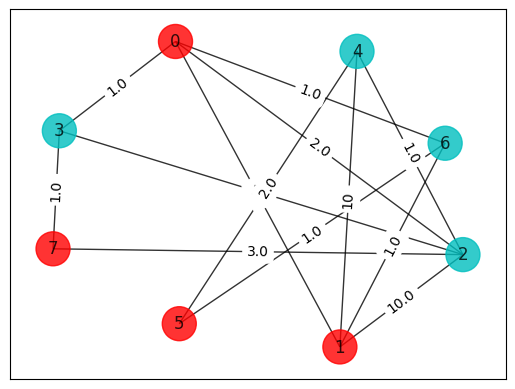

In [5]:
# brute force, evaluation des toutes les possibilité (de l'ordre de 2 puissance n)

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))] 
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
            if best_cost_brute < cost: 
                best_cost_brute = cost 
                xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))
colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))

### Optimizeur Classique

In [6]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 4*x_0*x_2 - 2*x_0*x_3 - 2*x_0*x_6 - 20*x_1*x_2 - 20*x_1*x_4
  - 2*x_1*x_6 - 2*x_2*x_3 - 2*x_2*x_4 - 6*x_2*x_7 - 2*x_3*x_7 - 4*x_4*x_5
  - 2*x_5*x_6 + 5*x_0 + 22*x_1 + 17*x_2 + 3*x_3 + 13*x_4 + 3*x_5 + 3*x_6 + 4*x_7

Subject to
  No constraints

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7



In [7]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -17.5
Ising Hamiltonian:
SparsePauliOp(['IIIIIIZZ', 'IIIIIZIZ', 'IIIIZIIZ', 'IZIIIIIZ', 'IIIIIZZI', 'IIIZIIZI', 'IZIIIIZI', 'IIIIZZII', 'IIIZIZII', 'ZIIIIZII', 'ZIIIZIII', 'IIZZIIII', 'IZZIIIII'],
              coeffs=[0.5+0.j, 1. +0.j, 0.5+0.j, 0.5+0.j, 5. +0.j, 5. +0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 1.5+0.j, 0.5+0.j, 1. +0.j, 0.5+0.j])


In [8]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 32.0
variable values: x_0=1.0, x_1=1.0, x_2=0.0, x_3=0.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0
status: SUCCESS


energy: -14.5
max-cut objective: -32.0
solution: [1. 1. 0. 0. 0. 1. 0. 1.]
solution objective: 32.0


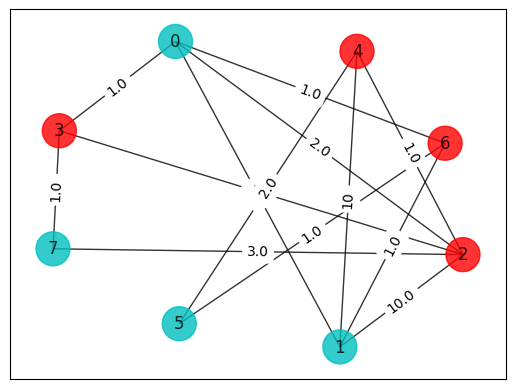

In [9]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## Version quantique (VQE)

In [10]:
algorithm_globals.random_seed = 123
seed = 10598
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)
# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)


/var/folders/8s/vmq_r89s3c31xtrbb7gbv2s80000gn/T/ipykernel_81757/730957295.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


objective function value: 32.0
variable values: x_0=0.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0
status: SUCCESS


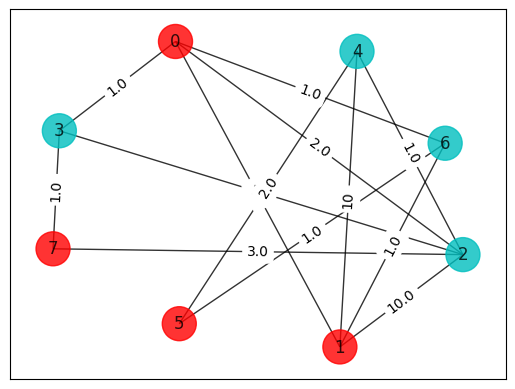

In [11]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

## Merci ! 
# Questions ? 